In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("diabetes.csv")

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.shape

(768, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


 - Veri Kalitesi Sorunları:

 
--> Glucose, BloodPressure, SkinThickness, Insulin, ve BMI özelliklerinde 0 değerleri, eksik veya hatalı veriyi işaret ediyor. 

--> Gerçek hayatta bu ölçümler 0 olamaz. Model oluşturmadan önce bu değerler için ön işleme yapılmalı (örneğin, medyan ile doldurma veya eksik veri atama).

--> DiabetesPedigreeFunction yani ailede diyabet öyküsü medyanı 0.372 ile 2.42 max değeri arasındadır. Dolayısıyla öykü varlığını 0 ve 1 olarak değiştireceğiz.

--> SkinThickness(Deri Kalınlığı) Kadınlarda >30 mm ve erkeklerde >23 mm TDKK değerleri, obezite riski taşıyan bireyler için eşik değer olarak kabul edilir.

Örneğin: SkinThickness ve Insulin için %25’lik dilimde 0 olması, ciddi bir veri eksikliği sorunu.

In [10]:
def impute_and_bound_values(df):
  
    df = df.rename(columns={'Outcome': 'Diyabet', 'DiabetesPedigreeFunction': 'Diyabet_Oykusu'})
    
    features_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Diyabet_Oykusu', 'Pregnancies', 'Age']
    medical_bounds = {
        'Glucose': (70.0, 200.0),
        'BloodPressure': (60.0, 90.0),
        'SkinThickness': (10.0, 40.0),  
        'Insulin': (16.0, 166.0),
        'BMI': (18.5, 45.0),
        'Diyabet_Oykusu': (0.0, 1.0),
        'Pregnancies': (0.0, 10.0),    
        'Age': (21.0, 70.0)           
    }
    
    print("\n0 Değerlerinin Sayısı:")
    for feature in features_to_impute:
        zero_count = (df[feature] == 0).sum()
        print(f"{feature}: {zero_count} hasta ({zero_count/len(df)*100:.2f}%)")
    
    print("\nTıbbi Aralık Dışındaki Değerler (0 Hariç):")
    for feature in features_to_impute:
        min_bound, max_bound = medical_bounds[feature]
        abnormal_count = len(df[(df[feature] > 0) & 
                               ((df[feature] < min_bound) | (df[feature] > max_bound))])
        print(f"{feature} (<{min_bound} veya >{max_bound}): {abnormal_count} hasta ({abnormal_count/len(df)*100:.2f}%)")
    
    for feature in features_to_impute:
        min_bound, max_bound = medical_bounds[feature]
        df[feature] = df[feature].mask((df[feature] == 0) | 
                                      (df[feature] < min_bound) | 
                                      (df[feature] > max_bound), np.nan)
    
    
    df['Diyabet_Oykusu'] = np.where(
        (df['Diyabet'] == 0) & (df['Diyabet_Oykusu'] <= 0.5), 0,
        np.where(
            (df['Diyabet'] == 0) & (df['Diyabet_Oykusu'] > 0.5), 1,
            np.where(
                (df['Diyabet'] == 1) & (df['Diyabet_Oykusu'] <= 0.5), 0,
                np.where(
                    (df['Diyabet'] == 1) & (df['Diyabet_Oykusu'] > 0.5), 1, np.nan
                )
            )
        )
    )
    
    median_by_outcome = df.groupby('Diyabet')[features_to_impute].median()
    print("\nDiyabet'e Göre Medyan Değerler (Önce):")
    print(median_by_outcome)
    
   
    median_by_outcome.loc[0, 'Glucose'] = 70.0   # Diyabetsiz için minimum değere yakın
    median_by_outcome.loc[0, 'Insulin'] = 20.0   # Diyabetsiz için test edilen düşük değere yakın
    median_by_outcome.loc[1, 'Glucose'] = 140.0  # Diyabetli için mevcut medyan
    median_by_outcome.loc[1, 'Insulin'] = 125.5  # Diyabetli için mevcut medyan
    
    for feature in features_to_impute:
        for outcome in [0, 1]:
            median_value = median_by_outcome.loc[outcome, feature]
            mask = (df['Diyabet'] == outcome) & (df[feature].isna())
            df.loc[mask, feature] = median_value
    
    for feature, bounds in medical_bounds.items():
        min_bound, max_bound = bounds
        df[feature] = df[feature].clip(lower=min_bound, upper=max_bound)
    
    print("\nImputation ve Sınırlandırma Sonrası Minimum ve Maksimum Değerler:")
    for feature in features_to_impute:
        min_value = df[feature].min()
        max_value = df[feature].max()
        print(f"{feature}: Min = {min_value:.2f}, Max = {max_value:.2f}")
    
    print("\n0, anormal ve aykırı değerler Diyabet'e göre medyan ile dolduruldu ve tıbbi aralıklarla sınırlandırıldı.")
    return df

df = impute_and_bound_values(df)


0 Değerlerinin Sayısı:
Glucose: 5 hasta (0.65%)
BloodPressure: 35 hasta (4.56%)
SkinThickness: 227 hasta (29.56%)
Insulin: 374 hasta (48.70%)
BMI: 11 hasta (1.43%)
Diyabet_Oykusu: 0 hasta (0.00%)
Pregnancies: 111 hasta (14.45%)
Age: 0 hasta (0.00%)

Tıbbi Aralık Dışındaki Değerler (0 Hariç):
Glucose (<70.0 veya >200.0): 11 hasta (1.43%)
BloodPressure (<60.0 veya >90.0): 124 hasta (16.15%)
SkinThickness (<10.0 veya >40.0): 78 hasta (10.16%)
Insulin (<16.0 veya >166.0): 134 hasta (17.45%)
BMI (<18.5 veya >45.0): 39 hasta (5.08%)
Diyabet_Oykusu (<0.0 veya >1.0): 51 hasta (6.64%)
Pregnancies (<0.0 veya >10.0): 34 hasta (4.43%)
Age (<21.0 veya >70.0): 2 hasta (0.26%)

Diyabet'e Göre Medyan Değerler (Önce):
         Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
Diyabet                                                          
0          108.0           72.0           26.0     83.0  30.05   
1          140.0           74.0           30.5    125.5  33.75   

         Diyabet_Oykusu

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,4.016927,2.470367,1.0,2.0,3.00,5.00,10.0
Glucose,768.0,121.658854,30.377130,70.0,99.0,117.00,140.25,199.0
BloodPressure,768.0,73.375000,7.467793,60.0,68.0,72.00,78.00,90.0
SkinThickness,768.0,27.119792,6.321202,10.0,25.0,26.00,30.50,40.0
Insulin,768.0,73.667969,49.740950,16.0,20.0,71.50,125.50,166.0
BMI,768.0,31.738542,5.701114,19.1,27.6,31.95,35.50,45.0
Diyabet_Oykusu,768.0,0.294271,0.456011,0.0,0.0,0.00,1.00,1.0
Age,768.0,33.111979,11.552294,21.0,24.0,29.00,40.25,70.0
Diyabet,768.0,0.348958,0.476951,0.0,0.0,0.00,1.00,1.0


In [12]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Diyabet_Oykusu', 'Age', 'Diyabet'],
      dtype='object')

In [13]:
df['Diyabet'].value_counts()

Diyabet
0    500
1    268
Name: count, dtype: int64

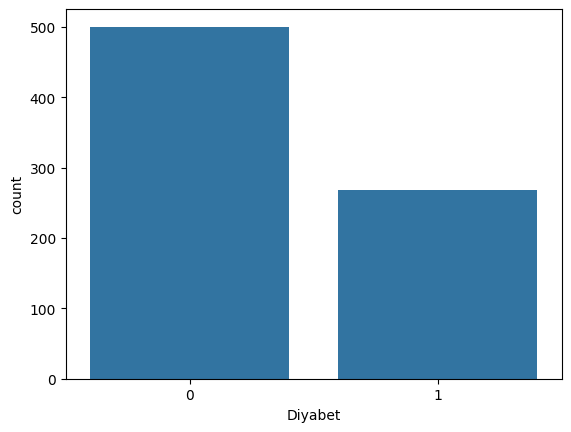

In [12]:
sns.countplot(x='Diyabet', data=df)
plt.show()

In [13]:
df["Diyabet"].value_counts() / len(df) * 100

Diyabet
0    65.104167
1    34.895833
Name: count, dtype: float64

- Diyabet Risk Faktörleri:

  -- > Glikoz ve BMI, diyabetle en güçlü ilişkili özelliklerdir. Ortalama glikoz (120.89) ve BMI (31.99), veri setindeki hastaların çoğunun diyabet veya prediyabet riski taşıdığını gösteriyor.

  -- > Ailede Diyabet öyküsü ve Pregnancies, genetik ve çevresel risk faktörlerini yansıtıyor.

  --> Age dağılımı genç olmasına rağmen, diyabet prevalansı (%35), popülasyonun yüksek riskli olduğunu (muhtemelen obezite ve genetik faktörler nedeniyle) gösteriyor.

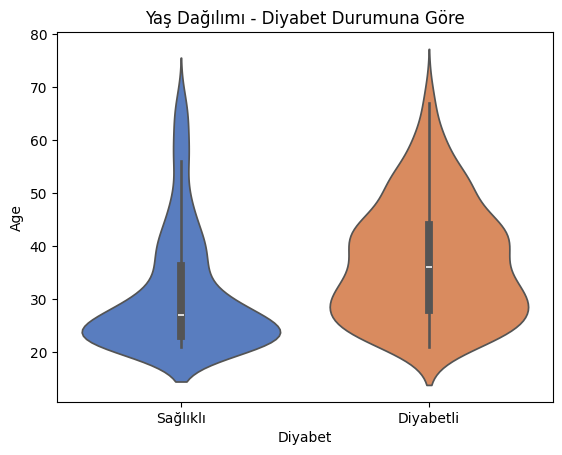

In [14]:
sns.violinplot(x='Diyabet', y='Age', data=df, palette="muted")
plt.xticks([0,1], ['Sağlıklı', 'Diyabetli'])
plt.title("Yaş Dağılımı - Diyabet Durumuna Göre")
plt.show()

Diyabetli olan ve Diyabetli olmayanların ortalama değişken değerleri

In [15]:
df.groupby("Diyabet").mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Diyabet_Oykusu,Age
Diyabet,,,,,,,,
0,3.482000,110.594000,72.566000,25.560000,46.736000,30.486400,0.25800,30.992000
1,5.014925,142.302239,74.884328,30.029851,123.914179,34.074627,0.36194,37.067164


Glukoz Değerlerinin Diyabet ile Kolerasyonu

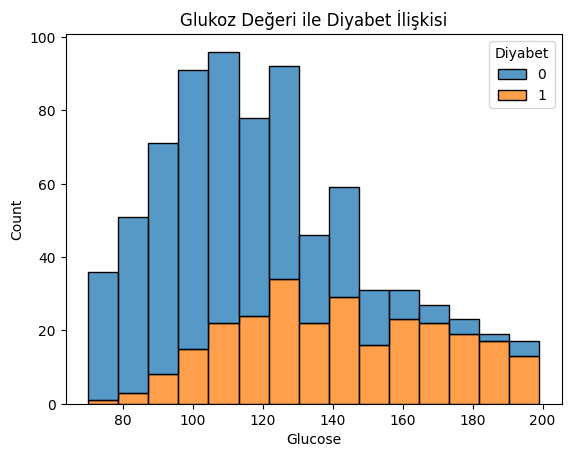

In [16]:
sns.histplot(data=df, x= "Glucose", hue ="Diyabet", multiple="stack")
plt.title("Glukoz Değeri ile Diyabet İlişkisi")
plt.show()


Isı Haritası ile Korelasyon İncelemesi

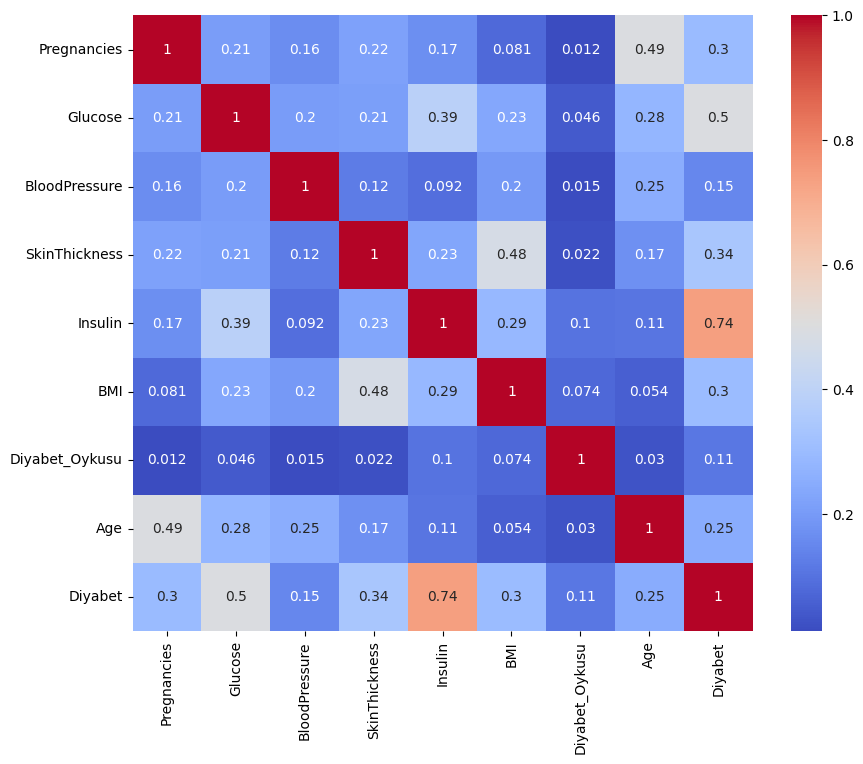

In [17]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

Diyabetli ve Sağlıklı Hastaların BMI, Yaş, Kan Basıncı ve Glukoz Değerlerinin Birbiri ile Korelasyonu

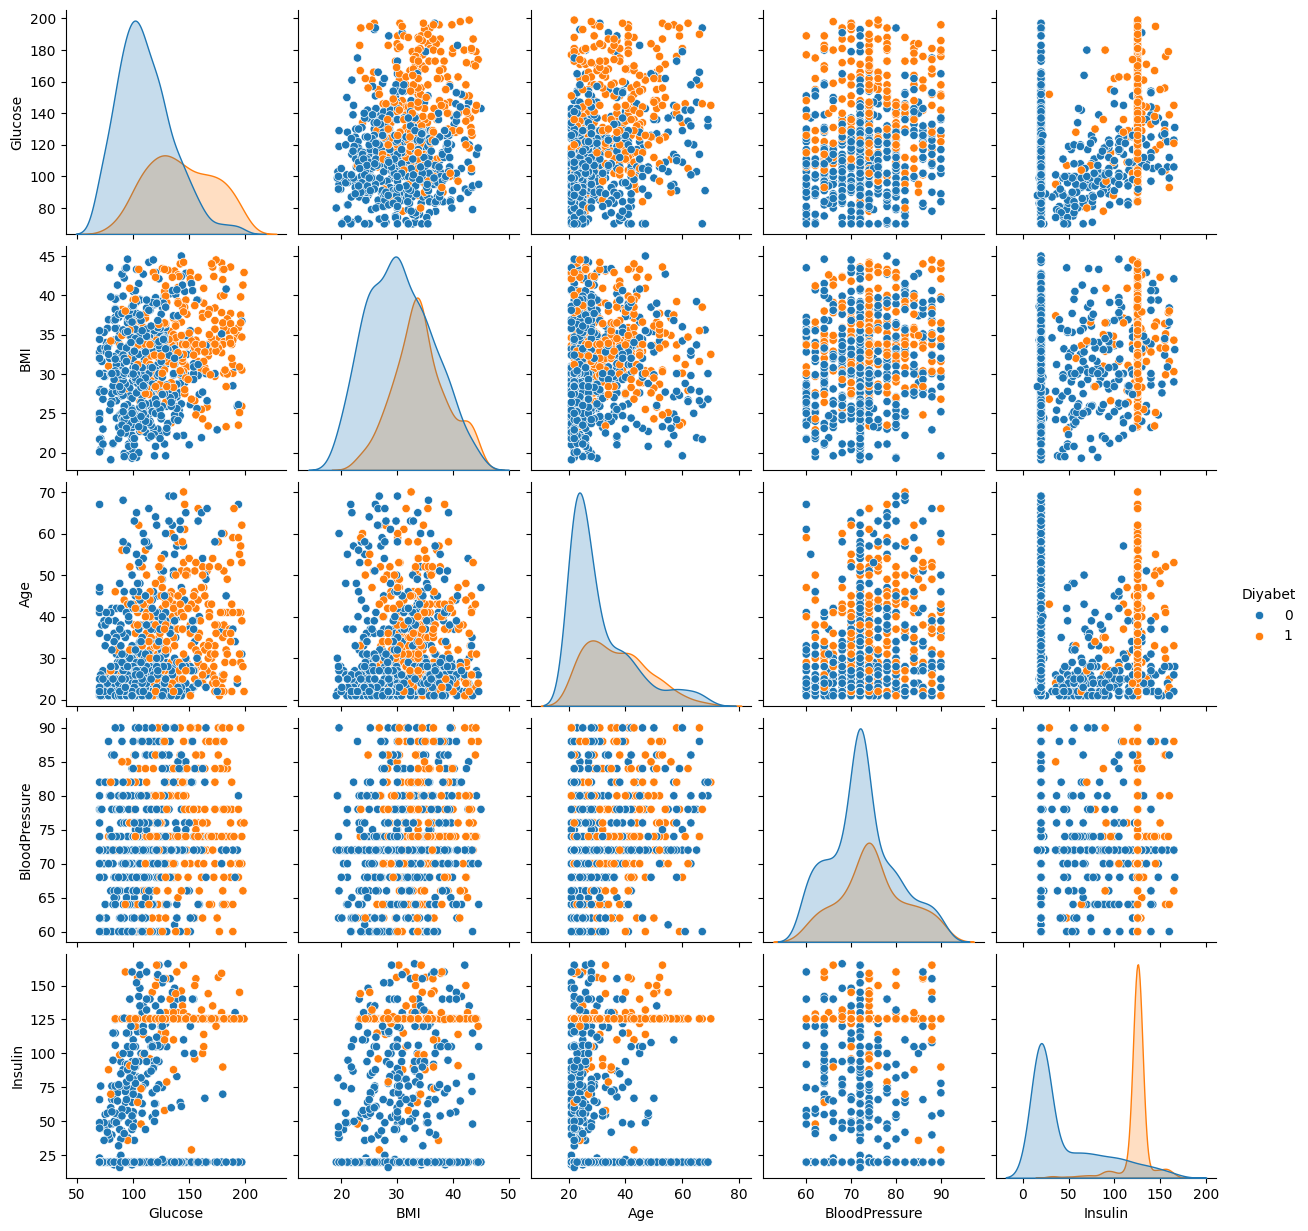

In [18]:
sns.pairplot(data=df, hue='Diyabet', vars=['Glucose', 'BMI', 'Age', 'BloodPressure', "Insulin"])
plt.show()

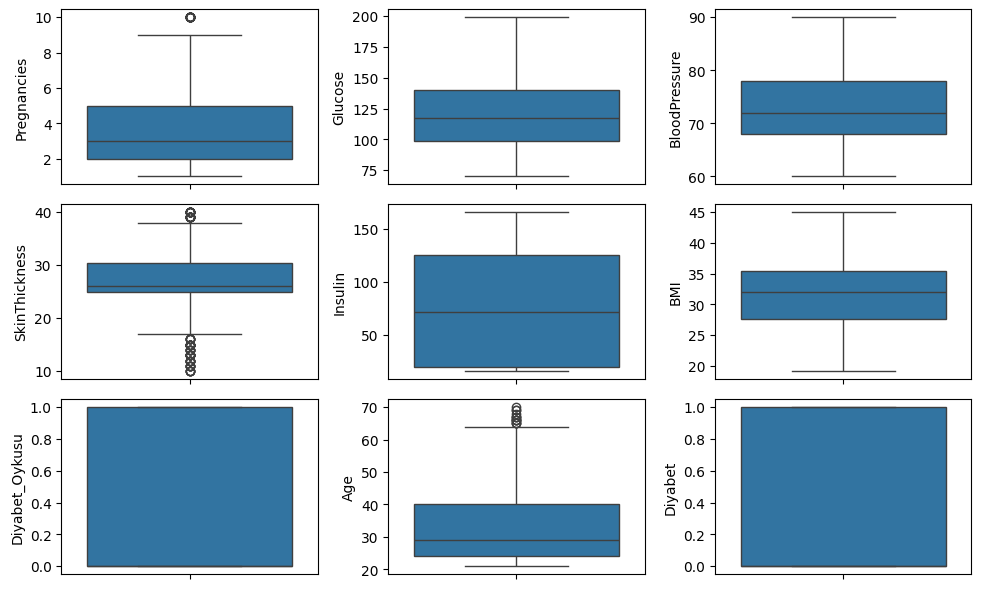

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(10, 6))

for i, col in enumerate(df.columns):
    sns.boxplot(data=df, y=col, ax=axes[i//3, i%3])

plt.tight_layout()
plt.show()

Aykırı Değer Analizi

In [20]:
def detect_outliers(df):
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.10)
        Q3 = df[col].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        print(f"{col} için aykırı değer sayısı: {len(outliers)}")

detect_outliers(df)

Pregnancies için aykırı değer sayısı: 0
Glucose için aykırı değer sayısı: 0
BloodPressure için aykırı değer sayısı: 0
SkinThickness için aykırı değer sayısı: 0
Insulin için aykırı değer sayısı: 0
BMI için aykırı değer sayısı: 0
Diyabet_Oykusu için aykırı değer sayısı: 0
Age için aykırı değer sayısı: 0
Diyabet için aykırı değer sayısı: 0


---

Data Preparation

---

In [21]:
X = df.drop("Diyabet", axis = 1)
y = df["Diyabet"]

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
import joblib

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

---

In [24]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Diyabet_Oykusu,Age
29,0.666667,0.000000,0.000000,0.000000,-0.488152,0.272152,0.0,0.553846
535,0.333333,0.363636,0.200000,0.818182,0.511848,0.120253,0.0,-0.369231
695,1.333333,0.606061,1.800000,-0.363636,0.511848,-0.196203,0.0,0.861538
557,1.666667,-0.169697,0.400000,0.000000,-0.488152,-0.525316,0.0,1.784615
836,0.666667,0.020849,1.130017,0.799096,0.511848,0.215003,1.0,0.140304


---

Model Eğitimi

---

In [25]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV



rf_params = {
    "n_estimators": [100, 200, 500, 1000],
    "max_features": [3, 5, 7],
    "min_samples_split": [2, 5, 10, 30],
    "max_depth": [3, 5, 8, None]
}


rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)


gs_cv = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    cv=10,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
).fit(X_train, y_train)



print("\nEn iyi parametreler:", gs_cv.best_params_)
print("En iyi skor (Accuracy):", gs_cv.best_score_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits

En iyi parametreler: {'max_depth': 8, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 100}
En iyi skor (Accuracy): 0.95625


In [26]:
best_model = gs_cv.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Seti Accuracy: {accuracy:.4f}")
print(f"Test Seti Classification Report:\n{classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes'])}")


Test Seti Accuracy: 0.9550
Test Seti Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.97      0.94      0.95        99
    Diabetes       0.94      0.97      0.96       101

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



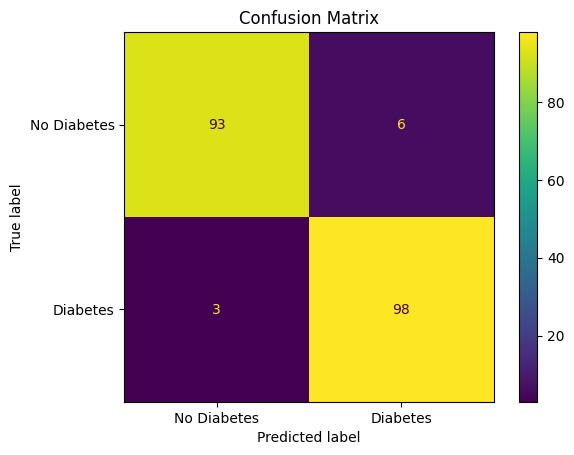

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

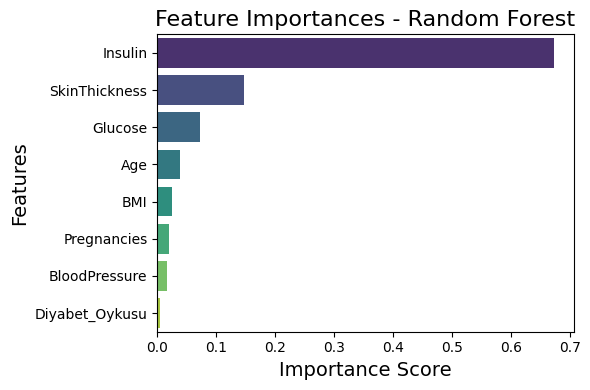

In [28]:
importances = best_model.feature_importances_


features = X.columns


feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})


feature_df = feature_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title("Feature Importances - Random Forest", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.tight_layout()
plt.show()

---

Modeli Kaydediyoruz

---

In [29]:
import joblib

joblib.dump(best_model, 'diabetes_rf_model.pkl')
print("Model 'diabetes_rf_model.pkl' olarak kaydedildi.")

Model 'diabetes_rf_model.pkl' olarak kaydedildi.


---